# Regression: Mutual Fund Analysis

In this chapter, we will use the skills that we have learned so far to analyze some mutual fund data.  In particular, we have end of day NAVs from two different funds, called `fund_1` and `fund_2`, as well as benchmark index, called `benchmark`.  The data spans from 2016Q1 to 2019Q3.

In our analysis we will do the following:


1. Calculate daily price returns for the benchmark and each of the two funds (ignoring dividends)
1. Calculate a rolling 250-day return for each fund and the benchmark, visualize the results.
1. Calculate a rolling 250-day volatility for each fund and the benchmark, visualize the results.
1. For each calendar quarter in the data set, calculate the excess return for each fund (vs the benchmark) and visualize this.
1. Create a correlation matrix of the three return histories (funds & benchmark) using daily returns of the 2 most recent years.
1. Regress each of the two funds vs the benchmark and calculate beta, alpha, and $R^2$ using the most recent 2 years of data.
1. Visualize the two sets of linear regression results.

## Loading Packages

Let's begin by importing the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Reading-In Data

Next, we'll read-in the data, rename the columns, and convert the `trade_date` column to `datetime`.

In [ ]:
# reading-in data
df_px_raw = pd.read_csv('mutual_fund_data.csv')
# renaming columns
df_px_raw.rename(
    columns={'Date':'trade_date', 'BM':'benchmark', 'Fund_1':'fund_1', 'Fund_2':'fund_2'}
    , inplace=True)
# converting data-type of trade_date
df_px_raw['trade_date'] = pd.to_datetime(df_px_raw['trade_date'])

df_px_raw.head()

,trade_date,benchmark,fund_1,fund_2
0,2015-12-31,203.8700,108.29,254.04
1,2016-01-01,203.8700,108.29,254.04
2,2016-01-04,201.0192,106.61,250.82
3,2016-01-05,201.3600,106.10,250.90
4,2016-01-06,198.8200,104.66,247.36


## Visualizing Raw Price Data

The **pandas** package was created by Wes McKinney when he was a quant at the hedge fund AQR.  Because of this, **pandas** was built with a lot of functionality that is particularly useful for working with financial timeseries.  This includes some rudimentary plotting functionality, which is built on top of the package **matplotlib**.  


Let's quickly plot the price series for our three funds using the `DataFrame.plot()` method.

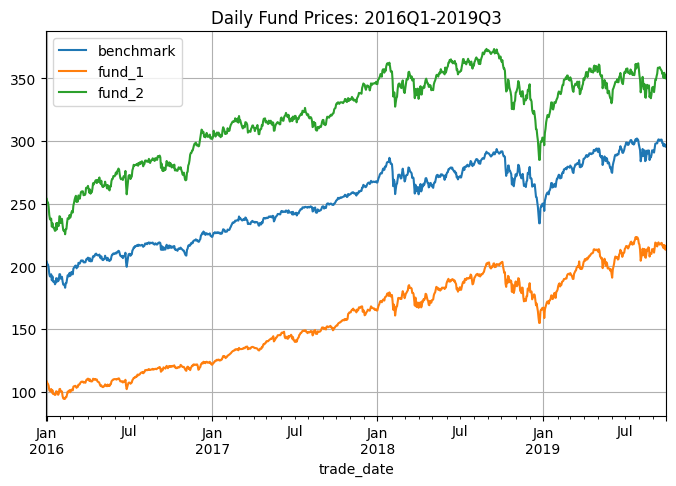

In [ ]:
df_px_raw.plot(
    x='trade_date', 
    y=['benchmark', 'fund_1', 'fund_2'],
    figsize=(8,5),
    title='Daily Fund Prices: 2016Q1-2019Q3',
    grid = True
);

---

**Code Challenge:** Copy and paste the code above and try setting `subplots=True`.

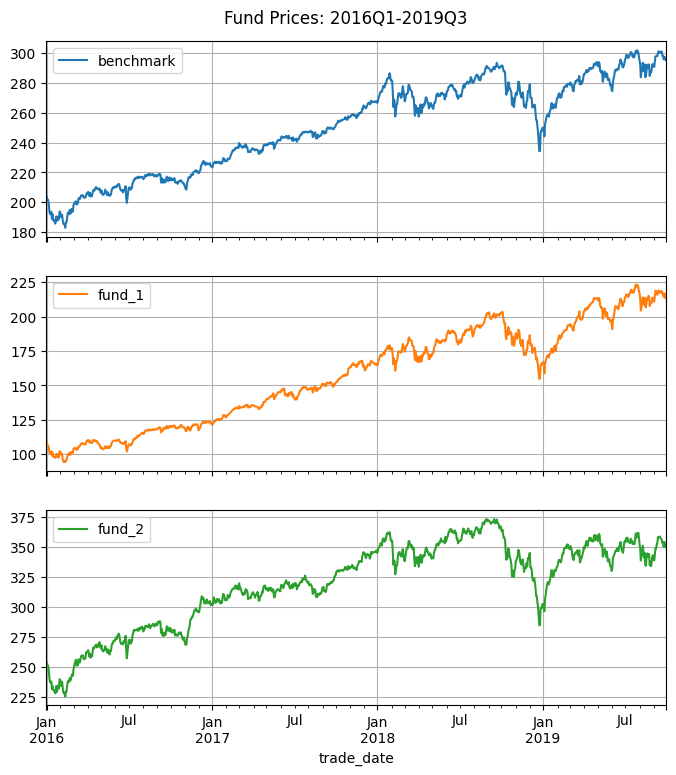

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
df_px_raw.plot(
    x='trade_date', 
    y=['benchmark', 'fund_1', 'fund_2'],
    figsize=(8,8),
    title='Fund Prices: 2016Q1-2019Q3',
    grid = True,
    subplots = True,
);
plt.subplots_adjust(top=0.94);

---

## Tidying the Data

Our data, in its current form, is not *tidy*. In order for data to be tidy, each row should be a single observation.  Currently, each row of `df_px_raw` is three price observations - one for each of the three funds - which will not allow for easy use of the `.groupby()` function. 

We can use the `pandas.melt()` method to tidy our data.

In [ ]:
df_px = \
    pd.melt(
        df_px_raw, 
        id_vars = ['trade_date'],
        value_vars = ['benchmark', 'fund_1', 'fund_2'], 
        var_name = 'symbol', 
        value_name = 'close',
    )

df_px.head()

,trade_date,symbol,close
0,2015-12-31,benchmark,203.8700
1,2016-01-01,benchmark,203.8700
2,2016-01-04,benchmark,201.0192
3,2016-01-05,benchmark,201.3600
4,2016-01-06,benchmark,198.8200


Our analysis will involve calculating quarterly statistics, so let's add columns `year`, `quarter`, and `month`.

In [ ]:
df_px['year'] = df_px['trade_date'].dt.year
df_px['quarter'] = df_px['trade_date'].dt.quarter
df_px['month'] = df_px['trade_date'].dt.month
df_px.head()

,trade_date,symbol,close,year,quarter,month
0,2015-12-31,benchmark,203.8700,2015,4,12
1,2016-01-01,benchmark,203.8700,2016,1,1
2,2016-01-04,benchmark,201.0192,2016,1,1
3,2016-01-05,benchmark,201.3600,2016,1,1
4,2016-01-06,benchmark,198.8200,2016,1,1


Let's also rearrange columns to make our table a little more human readable.

In [ ]:
df_px = df_px[['symbol','trade_date', 'year', 'quarter', 'month',  'close',]]
df_px.head()

,symbol,trade_date,year,quarter,month,close
0,benchmark,2015-12-31,2015,4,12,203.8700
1,benchmark,2016-01-01,2016,1,1,203.8700
2,benchmark,2016-01-04,2016,1,1,201.0192
3,benchmark,2016-01-05,2016,1,1,201.3600
4,benchmark,2016-01-06,2016,1,1,198.8200


## Visualizing the Tidy Price Data with **seaborn**

Let's now import the **seaborn** package, which a popular visualization package that is also built on top of **matplotlib**.

In [ ]:
import seaborn as sns
sns.set()

In the code below, we use `sns.relplot()` to graph the three fund price series using our data in its tidy form.  Notice that by setting `hue='symbol'`, the `sns.relplot()` function knows to graph the `close` prices for each of the three `symbols` separately and with three different colors.

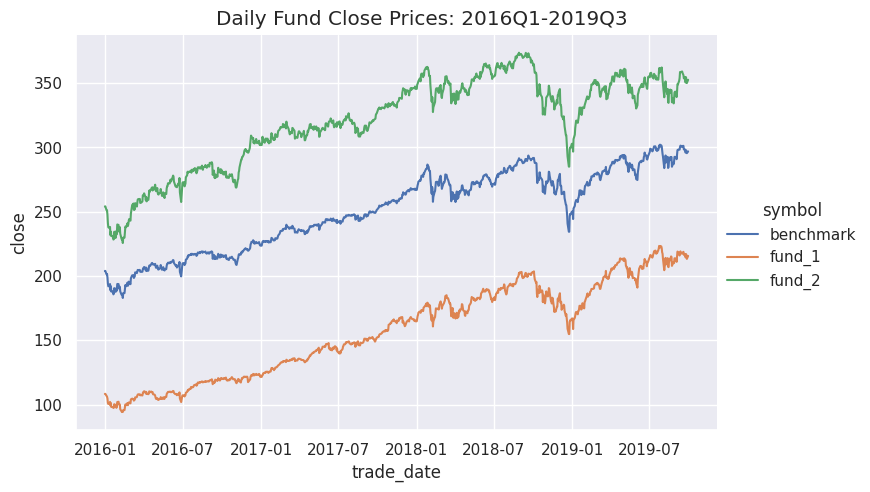

In [ ]:
g = \
sns.relplot(
    data = df_px, kind = 'line',
    x = 'trade_date', y = 'close', hue = 'symbol',
    aspect = 1.5,
);

# creating and tweaking the title
g.fig.suptitle('Daily Fund Close Prices: 2016Q1-2019Q3')
plt.subplots_adjust(top=0.93);

## Calculating Daily Returns (#1) 

Notice that our data  does not contain daily returns.

In [ ]:
df_px.head()

,symbol,trade_date,year,quarter,month,close
0,benchmark,2015-12-31,2015,4,12,203.8700
1,benchmark,2016-01-01,2016,1,1,203.8700
2,benchmark,2016-01-04,2016,1,1,201.0192
3,benchmark,2016-01-05,2016,1,1,201.3600
4,benchmark,2016-01-06,2016,1,1,198.8200


Now that our data is tidy, we can easily obtain daily log-returns using a grouped calculation.  

We use log-returns because, they are very close in value to simple returns, and multi-day log-returns are easily calculated as sums of single-day returns.

In [ ]:
df_px['daily_ret'] = \
    np.log(df_px['close']).groupby(df_px['symbol']).diff() #log returns
df_px.head()

,symbol,trade_date,year,quarter,month,close,daily_ret
0,benchmark,2015-12-31,2015,4,12,203.8700,NaN
1,benchmark,2016-01-01,2016,1,1,203.8700,0.000000
2,benchmark,2016-01-04,2016,1,1,201.0192,-0.014082
3,benchmark,2016-01-05,2016,1,1,201.3600,0.001694
4,benchmark,2016-01-06,2016,1,1,198.8200,-0.012694


---

**Code Challenge:** Verify that all the log-returns on the first date in the data set are `NaN`.

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
df_px[df_px['trade_date'] == np.min(df_px['trade_date'])]

,symbol,trade_date,year,quarter,month,close,daily_ret
0,benchmark,2015-12-31,2015,4,12,203.87,NaN
978,fund_1,2015-12-31,2015,4,12,108.29,NaN
1956,fund_2,2015-12-31,2015,4,12,254.04,NaN


 ---

## Rolling 252-day Return (#2)

Now that we have daily log-returns, we can easily calculate a rolling 252-day return by using the `.rolling()` method.

In [ ]:
df_px['ret_252'] = \
    df_px['daily_ret'].groupby(df_px['symbol']).rolling(252).sum().values
df_px.head()

,symbol,trade_date,year,quarter,month,close,daily_ret,ret_252
0,benchmark,2015-12-31,2015,4,12,203.8700,NaN,NaN
1,benchmark,2016-01-01,2016,1,1,203.8700,0.000000,NaN
2,benchmark,2016-01-04,2016,1,1,201.0192,-0.014082,NaN
3,benchmark,2016-01-05,2016,1,1,201.3600,0.001694,NaN
4,benchmark,2016-01-06,2016,1,1,198.8200,-0.012694,NaN


Next we'll use `sns.FacetGrid()` to graph three separate subplots of the rolling returns.

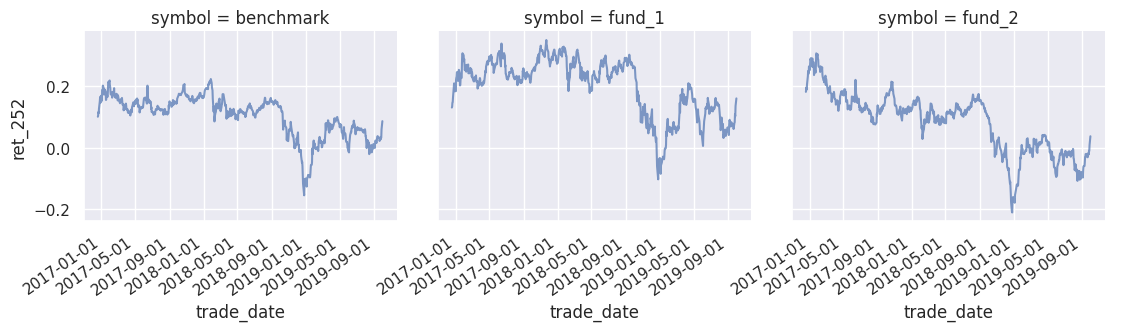

In [ ]:
g = sns.FacetGrid(df_px, col='symbol', aspect=1.25, height=3,)
g.map(plt.plot, 'trade_date', 'ret_252', alpha=0.7,)
g.add_legend();
g.set_xticklabels(rotation=35, horizontalalignment='right');

---

**Code Challenge:** Copy and paste the code above, and try changing `col='symbol'` to `row='symbol'`.

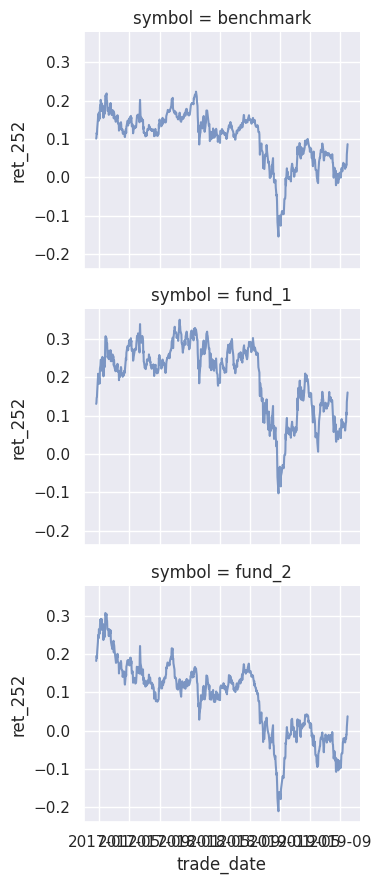

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
g = sns.FacetGrid(df_px, row='symbol', aspect=1.25, height=3)
g.map(plt.plot, 'trade_date', 'ret_252', alpha=0.7, )
g.add_legend();

--- 

## Rolling 252-day Volatility (#3)

We can calculate a rolling 252-day volatility in a similar fashion as the rolling returns.

In [ ]:
df_px['vol_252'] = \
    df_px['daily_ret'].groupby(df_px['symbol']).rolling(252).std().values * np.sqrt(252)
df_px.head()

,symbol,trade_date,year,quarter,month,close,daily_ret,ret_252,vol_252
0,benchmark,2015-12-31,2015,4,12,203.8700,NaN,NaN,NaN
1,benchmark,2016-01-01,2016,1,1,203.8700,0.000000,NaN,NaN
2,benchmark,2016-01-04,2016,1,1,201.0192,-0.014082,NaN,NaN
3,benchmark,2016-01-05,2016,1,1,201.3600,0.001694,NaN,NaN
4,benchmark,2016-01-06,2016,1,1,198.8200,-0.012694,NaN,NaN


This code creates a `seaborn.FacetGrid()` of the rolling volatilities.

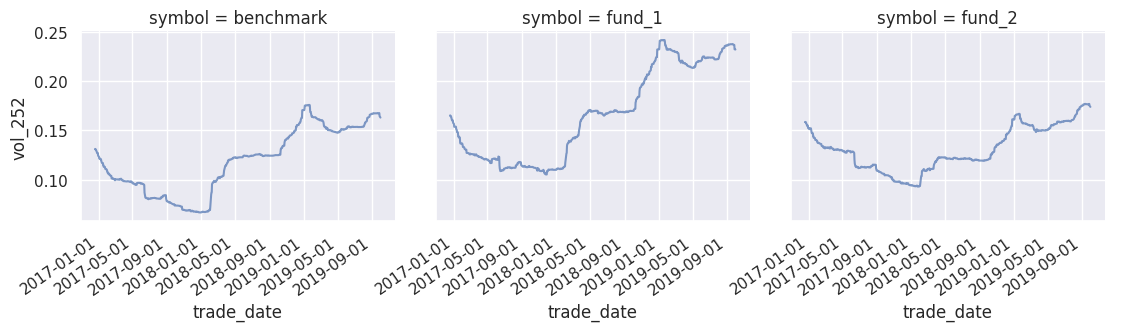

In [ ]:
g = sns.FacetGrid(df_px, col='symbol', aspect=1.25, height=3,)
g.map(plt.plot, 'trade_date', 'vol_252', alpha=0.7)
g.set_xticklabels(rotation=35, horizontalalignment='right');
g.add_legend();

The following code uses **pandas** to graph the rolling returns and volatility on the same plot for `fund_1`.

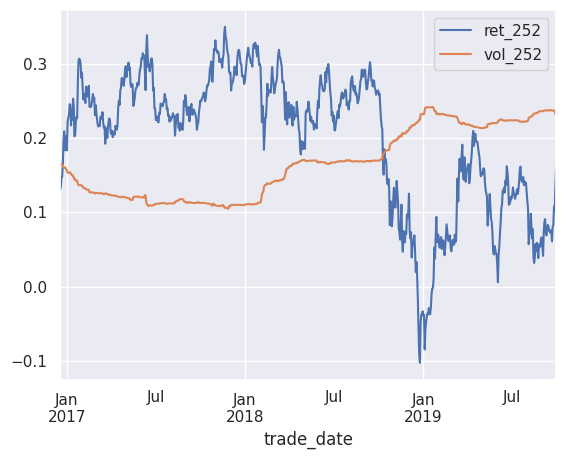

In [ ]:
# filtering conditions
bln_symbol = df_px['symbol'] == 'fund_1'
bln_nans = ~(np.isnan(df_px['ret_252']))
bln_filter = bln_symbol & bln_nans

# graphing
df_px[bln_filter].plot(x='trade_date', y=['ret_252', 'vol_252']);

**Code Challenge** Copy and paste the above code and modify it to graph only the data from the beginning of 2019 and onwards.

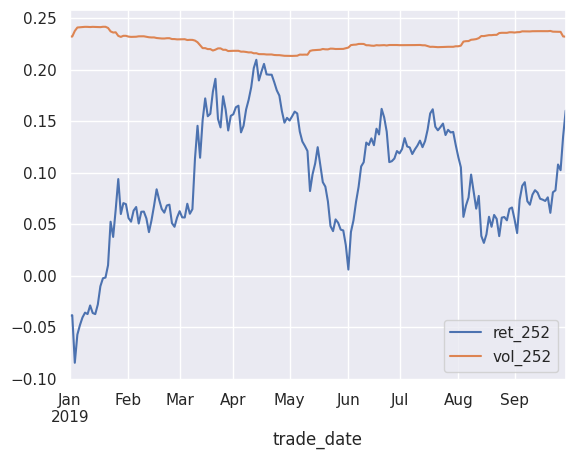

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
bln_symbol = df_px['symbol'] == 'fund_1'
bln_date = df_px['trade_date'] >= '2019-01-01'
bln_filter = bln_symbol & bln_date

df_px[bln_filter].plot(x='trade_date', y=['ret_252', 'vol_252']);

## Quarterly Returns and Excess Return (#4)

Our next analysis objective is to calculate quarterly excess returns for `fund_1` and `fund_2` relative the `benchmark`.

As we can see, `df_px` consist of daily data.

In [ ]:
df_px.head()

,symbol,trade_date,year,quarter,month,close,daily_ret,ret_252,vol_252
0,benchmark,2015-12-31,2015,4,12,203.8700,NaN,NaN,NaN
1,benchmark,2016-01-01,2016,1,1,203.8700,0.000000,NaN,NaN
2,benchmark,2016-01-04,2016,1,1,201.0192,-0.014082,NaN,NaN
3,benchmark,2016-01-05,2016,1,1,201.3600,0.001694,NaN,NaN
4,benchmark,2016-01-06,2016,1,1,198.8200,-0.012694,NaN,NaN


Calculating the quarterly returns is a straight-forward application of `.groupby().agg()`.

In [ ]:
df_quarter = \
    df_px[df_px.year > 2015] \
        .groupby(['symbol', 'year', 'quarter'])['daily_ret'].agg([np.sum]).reset_index() \
        .rename(columns={'sum':'quarterly_ret'})

df_quarter.head()

,symbol,year,quarter,quarterly_ret
0,benchmark,2016,1,0.008061
1,benchmark,2016,2,0.019061
2,benchmark,2016,3,0.032062
3,benchmark,2016,4,0.032879
4,benchmark,2017,1,0.053184


Since we ultimately want to calculate excess return relative to the `benchmark`, it would be helpful to have the `benchmark` returns as a separate column in `df_quarter`.

In order to do this, let's first separate out the `benchmark` quarterly returns into a separate `DataFrame` called `df_bench`.

In [ ]:
df_bench = \
    df_quarter[df_quarter['symbol'] == 'benchmark'] \
    [['year', 'quarter', 'quarterly_ret']] \
    .rename(columns={'quarterly_ret':'bench_ret'})

df_bench.head()

,year,quarter,bench_ret
0,2016,1,0.008061
1,2016,2,0.019061
2,2016,3,0.032062
3,2016,4,0.032879
4,2017,1,0.053184


In order to add the `bench_ret` column to `df_quarter` we will utilize a `left-join`.

In [ ]:
df_excess = \
    pd.merge(
        df_quarter, df_bench, how='left',
        left_on=['year','quarter'], right_on=['year', 'quarter']
    )

df_excess.head()

,symbol,year,quarter,quarterly_ret,bench_ret
0,benchmark,2016,1,0.008061,0.008061
1,benchmark,2016,2,0.019061,0.019061
2,benchmark,2016,3,0.032062,0.032062
3,benchmark,2016,4,0.032879,0.032879
4,benchmark,2017,1,0.053184,0.053184


Finally, we can caluclate excess return for each of the funds.

In [ ]:
df_excess['excess_ret'] = df_excess['quarterly_ret'] - df_excess['bench_ret']
df_excess['year_quarter'] = df_excess['year'] * 100 + df_excess['quarter']
df_excess = df_excess[['symbol', 'year', 'quarter', 'year_quarter', 'quarterly_ret', 'bench_ret', 'excess_ret']]
df_excess.head()

,symbol,year,quarter,year_quarter,quarterly_ret,bench_ret,excess_ret
0,benchmark,2016,1,201601,0.008061,0.008061,0.0
1,benchmark,2016,2,201602,0.019061,0.019061,0.0
2,benchmark,2016,3,201603,0.032062,0.032062,0.0
3,benchmark,2016,4,201604,0.032879,0.032879,0.0
4,benchmark,2017,1,201701,0.053184,0.053184,0.0


Next, we create a bar-plot with of the three funds quarterly returns.

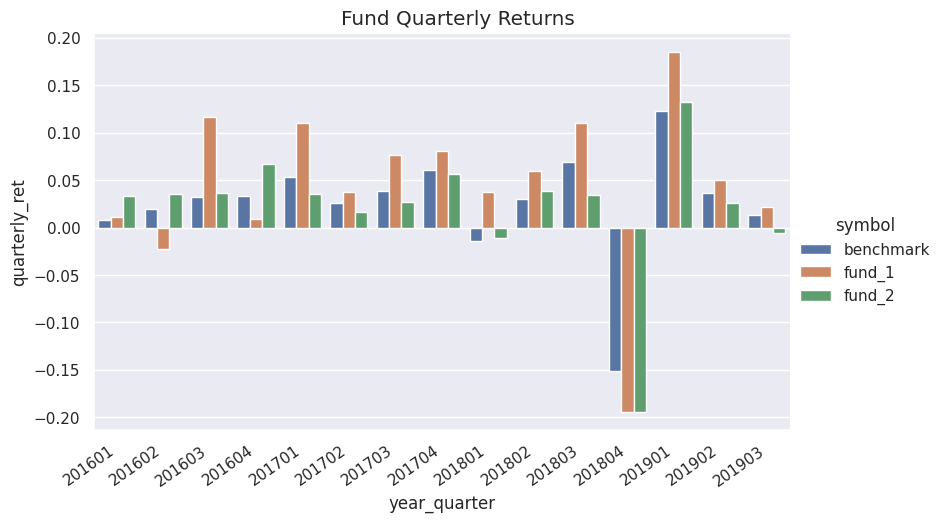

In [ ]:
g = \
    sns.catplot(
        data=df_excess, x="year_quarter", y="quarterly_ret",
        hue="symbol", kind="bar",
        aspect= 1.65, 
    )
g.fig.suptitle('Fund Quarterly Returns')
g.set_xticklabels(rotation=35, horizontalalignment='right')
plt.subplots_adjust(top=0.93);

And finally, we create a bar-plot of the excess returns of `fund_1` and `fund_2`.

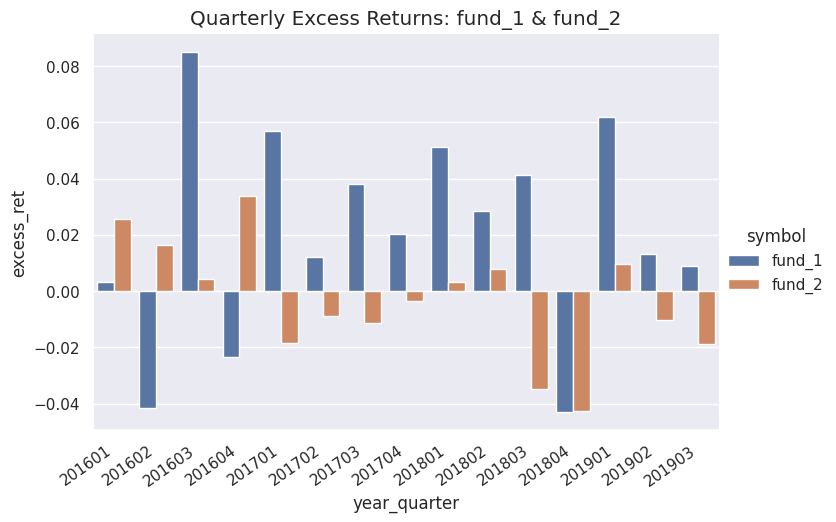

In [ ]:
g = \
    sns.catplot(
        data=df_excess[df_excess.symbol != 'benchmark'],
        x="year_quarter", y="excess_ret", 
        hue="symbol", kind="bar",
        aspect=1.5
    );
g.fig.suptitle('Quarterly Excess Returns: fund_1 & fund_2')
g.set_xticklabels(rotation=35, horizontalalignment='right')
plt.subplots_adjust(top=0.93);

## Wrangling Returns Data

For the remainder of the tutorial, will be helpful to have an *untidy* `DataFrame` with the daily returns for the three funds in separate columns. 

Let's first separate out the returns for each fund into their own `DataFrames`.

In [ ]:
cols = ['trade_date', 'daily_ret']
df_bench = \
    df_px[df_px.symbol == 'benchmark'][cols].copy().rename(columns={'daily_ret':'benchmark'})
df_fund1 = \
    df_px[df_px.symbol == 'fund_1'][cols].copy().rename(columns={'daily_ret':'fund_1'})
df_fund2 = \
    df_px[df_px.symbol == 'fund_2'][cols].copy().rename(columns={'daily_ret':'fund_2'})

Next, we `left-join` these three `DataFrames` together into a single variable called `df_ret`. 

In [ ]:
df_ret = \
    df_bench \
        .merge(right=df_fund1, how='left', left_on='trade_date', right_on='trade_date') \
        .merge(right=df_fund2, how='left', left_on='trade_date', right_on='trade_date') \
        .query('trade_date > "2015-12-31"')
df_ret.head()

,trade_date,benchmark,fund_1,fund_2
1,2016-01-01,0.000000,0.000000,0.000000
2,2016-01-04,-0.014082,-0.015635,-0.012756
3,2016-01-05,0.001694,-0.004795,0.000319
4,2016-01-06,-0.012694,-0.013665,-0.014210
5,2016-01-07,-0.024284,-0.032729,-0.025882


## Pair-Plots and Correlation Matrix (#5)

In a subsequent section, we will perform regressions on the two most recent years of data.

Prior to modeling, I find it useful to look at scatter plots and correlations.

As a first step, let's programmatically calculate the start date for our analysis.  We will utilize the `numpy.timedelta` data structure for this purpose.

In [ ]:
dt_curr = df_ret.sort_values(['trade_date'])[-1:]['trade_date'].values[0]
dt_start = dt_curr - np.timedelta64(730, 'D')

print(dt_curr)
print(dt_start)

2019-09-30T00:00:00.000000000
2017-09-30T00:00:00.000000000


Next, we use the `seaborn.pairplot()` function to quickly graph all the pairwise correlatior for two years of fund data.

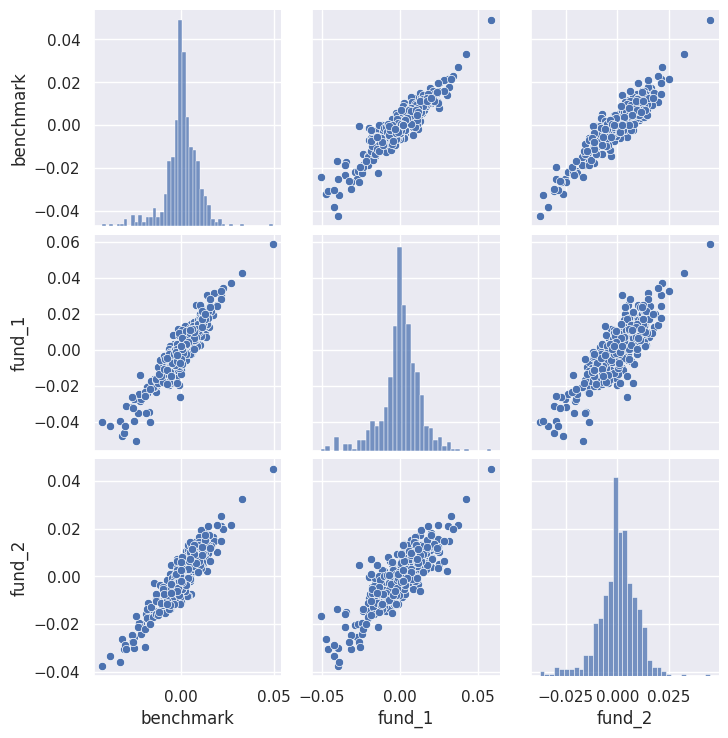

In [ ]:
cols = ['benchmark', 'fund_1', 'fund_2']
sns.pairplot(
    df_ret[df_ret['trade_date'] > dt_start][cols]
);

Clearly all three of our returns are highly correlated.  

Let's use the `DataFrame.corr()` method to calculate the correlations explicitly.

In [ ]:
cols = ['benchmark', 'fund_1', 'fund_2']
df_ret[df_ret['trade_date'] > dt_start][cols].corr()

,benchmark,fund_1,fund_2
benchmark,1.000000,0.927068,0.919859
fund_1,0.927068,1.000000,0.836144
fund_2,0.919859,0.836144,1.000000


---

**Code Challenge:** Copy and paste the above correlation code and modify it calculate the correlations for the entirety of the data set.

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
cols = ['benchmark', 'fund_1', 'fund_2']
df_ret[cols].corr()

,benchmark,fund_1,fund_2
benchmark,1.000000,0.914292,0.914148
fund_1,0.914292,1.000000,0.812403
fund_2,0.914148,0.812403,1.000000


--- 

## Regression of Funds against Benchmark (#6 and #7)

Finally, we will fit regressions of `fund_1` and `fund_2` against the `benchmark`.

In order to do this, we will utilize the **sklearn** package which is extremely useful for implementing a variety of machine learning techniques.

Let's begin by importing the `LinearRegression()` constructor function from **sklearn**. 

In [ ]:
from sklearn.linear_model import LinearRegression

We again want to restrict our analysis to the most recent two years, so let's recalculate `dt_start` just for good measure. 

In [ ]:
dt_curr = df_ret.sort_values(['trade_date'])[-1:]['trade_date'].values[0]
dt_start = dt_curr - np.timedelta64(730, 'D')

### Fund 1

Let's begin by regressing `fund_1` against the `benchmark`.

As a preliminary step, let's graph the scatter plot of the returns series.

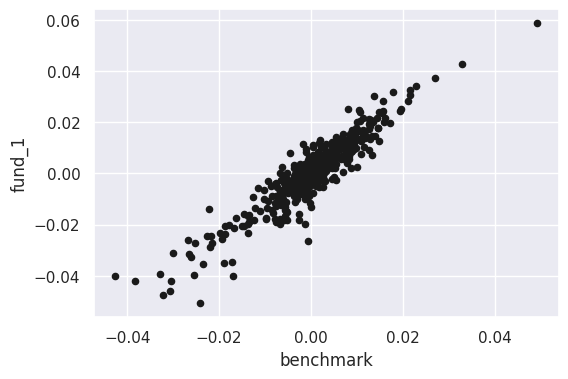

In [ ]:
df_ret \
    [df_ret.trade_date > dt_start] \
    .plot.scatter('benchmark', 'fund_1', c='k', figsize=(6, 4));

The first step in using **sklearn** for a regression analysis is to instantiate a regression model object as assign it to a variable, which we will call `reg_fund1`.

In [ ]:
reg_fund1 = LinearRegression(fit_intercept=True)

Next, let's separate out the `benchmark` returns and the `fund_1` returns into their own `DataFrames`.

In [ ]:
df_bm = df_ret[['benchmark']][df_ret.trade_date > dt_start]
df_fund1 = df_ret[['fund_1']][df_ret.trade_date > dt_start]

To fit the regression we call the `.fit()` method of our model object `reg_fund1`.

In [ ]:
reg_fund1.fit(X = df_bm, y = df_fund1)

LinearRegression()

The coefficients $(\beta)$ and the y-intercept $(\alpha)$ are attributes of `reg_fund1` which we can access as follows:

In [ ]:
print("beta:  " + str(np.round(reg_fund1.coef_[0, 0], 4)))
print("alpha: " + str(np.round(reg_fund1.intercept_[0], 4)))

beta:  1.2982
alpha: 0.0003


Every class of machine learning model has a `.score()` method, which gives some kind of accuracy measure.  For `LinearRegression` the `.score()` gives the $R^2$.

In [ ]:
reg_fund1.score(df_ret[['benchmark']], df_ret[['fund_1']])

0.8349465372078845

Let's use **pandas** plotting along with `matplotlib.pyplot` to graph our regression line along with the scatter plot of the data:

/home/pritam/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


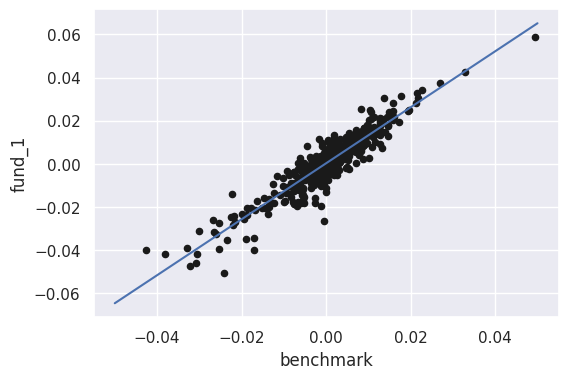

In [ ]:
xfit = np.linspace(-0.05, 0.05, 100)           # range of line
yfit = reg_fund1.predict(xfit[:, np.newaxis])  # model values in range


df_ret \
    [df_ret.trade_date > dt_start] \
    .plot.scatter('benchmark', 'fund_1', c='k', figsize=(6, 4));
plt.plot(xfit, yfit);

### Fund 2

Let's implement the same kind of regression analysis for `fund_2`.

**Scatter Plot of `fund_2` vs `benchmark`**

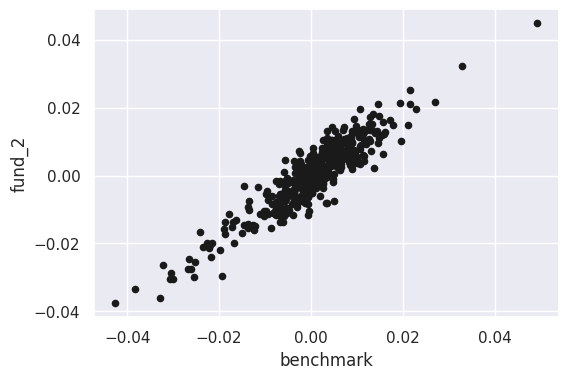

In [ ]:
df_ret\
    [df_ret.trade_date > dt_start]\
    .plot.scatter('benchmark', 'fund_2', c='k', figsize=(6, 4));

**Instantiate a `LinearRegression` Object**

In [ ]:
reg_fund2 = LinearRegression(fit_intercept=True)

**Separate out Features and Labels for Regression Analysis**

In [ ]:
df_bm = df_ret[['benchmark']][df_ret.trade_date > dt_start]
df_fund2 = df_ret[['fund_2']][df_ret.trade_date > dt_start]

**Fit the Regression Model**

In [ ]:
reg_fund2.fit(X = df_bm, y = df_fund2)

LinearRegression()

**Print Coefficients**

In [ ]:
print(reg_fund2.coef_)
print(reg_fund2.intercept_)

[[0.94373491]]
[-0.00015386]


**Check the $R^2$**

In [ ]:
reg_fund2.score(df_ret[['benchmark']], df_ret[['fund_1']])

0.7823936517887883

**Plot the Fitted Regression Line**

/home/pritam/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


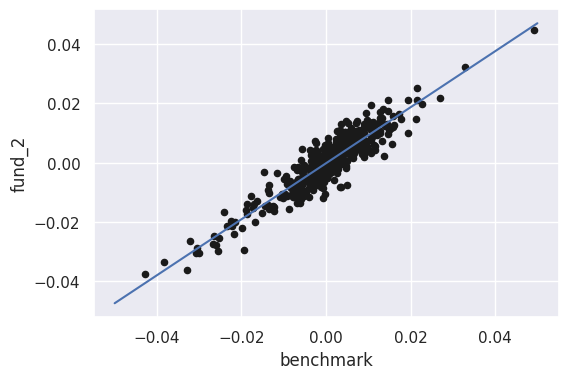

In [ ]:
xfit = np.linspace(-0.05, 0.05, 100)           # range of line
yfit = reg_fund2.predict(xfit[:, np.newaxis])  # model values in range


df_ret \
    [df_ret.trade_date > dt_start] \
    .plot.scatter('benchmark', 'fund_2', c='k', figsize=(6, 4));
plt.plot(xfit, yfit);